In [8]:
import sys
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2

path_before = sys.path
sys.path.append("/workspaces/src/rPPG-Toolbox")

import neural_methods.model.PhysNet as PhysNet

sys.path = path_before


dataset_path = "/mnt/results/preprocessed_rppgToolbox/VitalVideos_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DDEEPSTAB_amp10.0"
model_path = "/workspaces/src/rPPG-Toolbox/runs/exp/VitalVideos_and_UBFC_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DNone_amp10.0/PreTrainedModels/VitalLens_Physnet_best.pth"
        

In [9]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model_path, frames=160):
        super(ModelWrapper, self).__init__()
        self.model = PhysNet.PhysNet_padding_Encoder_Decoder_MAX(frames=frames)
        self.model.load_state_dict(torch.load(model_path, map_location="cpu"))

    def forward(self, x):
        ppg, _, _, _ = self.model(x)
        return ppg

In [10]:
model = ModelWrapper(model_path)
model.eval()

ModelWrapper(
  (model): PhysNet_padding_Encoder_Decoder_MAX(
    (ConvBlock1): Sequential(
      (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (ConvBlock2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (ConvBlock3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (ConvBlock4): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [11]:
in_files = os.listdir(dataset_path)
in_files = [f for f in in_files if "input" in f and f.endswith(".compressed.npz")]
in_files = sorted(in_files)

file_to_use = in_files[20]
input_path = os.path.join(dataset_path, file_to_use)
print(f"Using input file: {input_path}")

input_tensor = np.load(input_path)['array1']
input_tensor = np.expand_dims(input_tensor, axis=0)
input_tensor = np.transpose(input_tensor, (0, 4, 1, 2, 3))
standardized_input = input_tensor[:, 3:, :, :, :]
diff_normalized_input = input_tensor[:, :3, :, :, :]

print(diff_normalized_input.shape)

Using input file: /mnt/results/preprocessed_rppgToolbox/VitalVideos_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DDEEPSTAB_amp10.0/103_input0.npy.compressed.npz
(1, 3, 160, 72, 72)


In [12]:
target_layer = model.model.ConvBlock3[0]  # For example, a conv layer in ResNet-3D
target_filter = 5  # Which filter to visualize

In [13]:
activations = []

def hook_fn(module, input, output):
    activations.append(output)

hook = target_layer.register_forward_hook(hook_fn)


In [14]:
# Size: [1, C, T, H, W] – e.g., [1, 3, 16, 64, 64]
input_tensor = torch.randn(1, 3, 16, 64, 64, requires_grad=True, device='cpu')

optimizer = torch.optim.Adam([input_tensor], lr=0.1)


In [18]:
for i in range(30):
    optimizer.zero_grad()
    activations.clear()

    model(input_tensor)  # Forward pass

    # Get activation for the chosen filter
    activation = activations[0][0, target_filter]  # Shape: [T', H', W']

    # Maximize mean activation
    loss = activation.mean()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")


Step 0, Loss: 30.4866
Step 10, Loss: 31.2597
Step 20, Loss: 27.7915


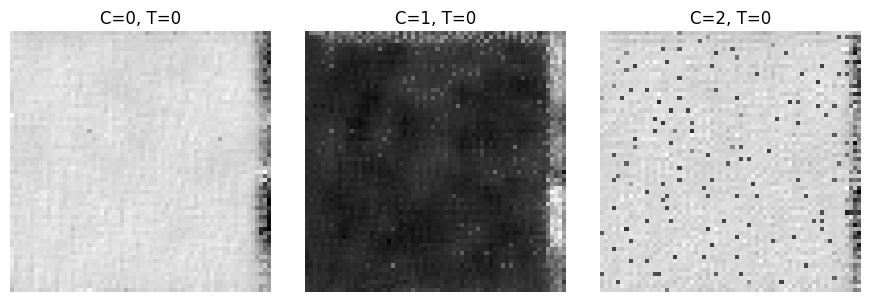

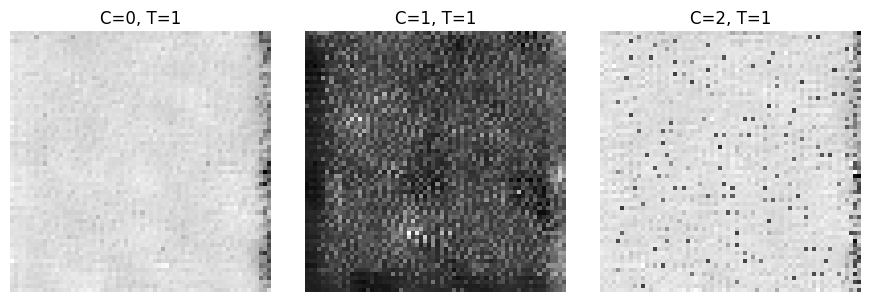

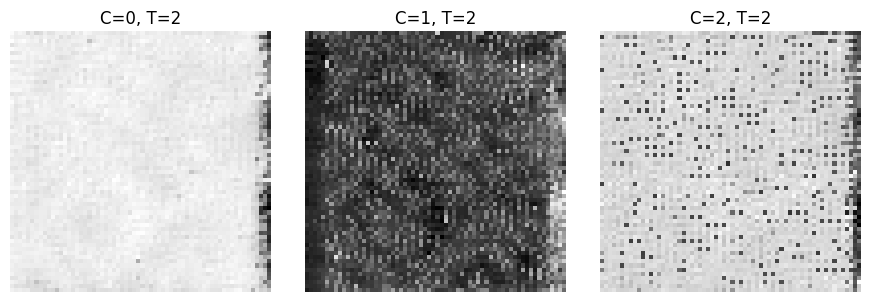

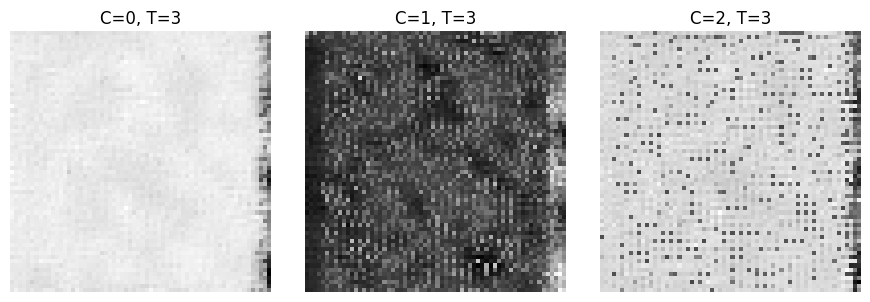

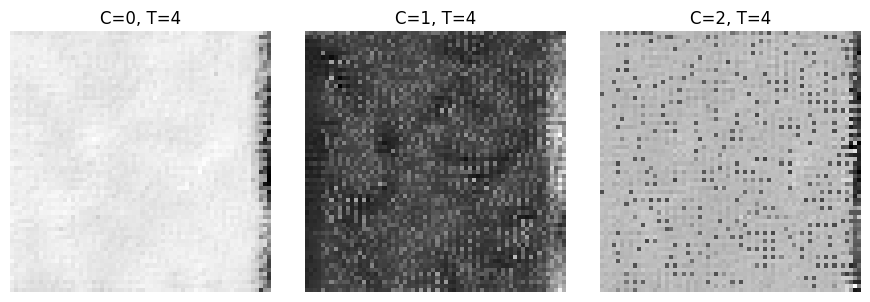

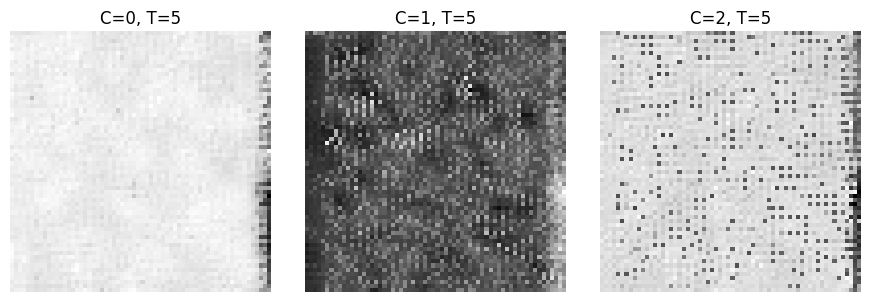

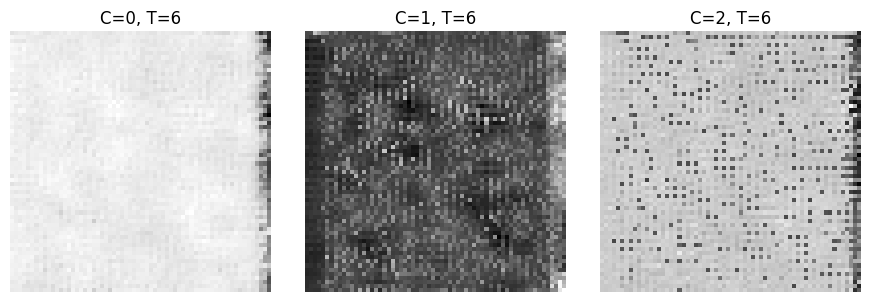

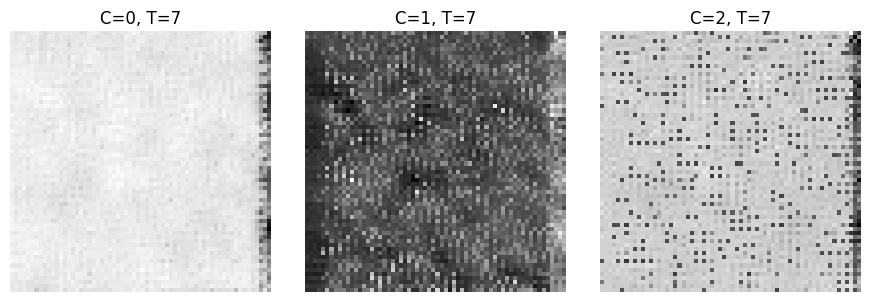

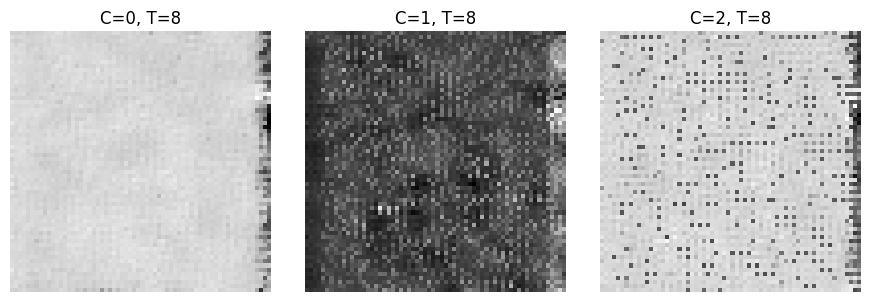

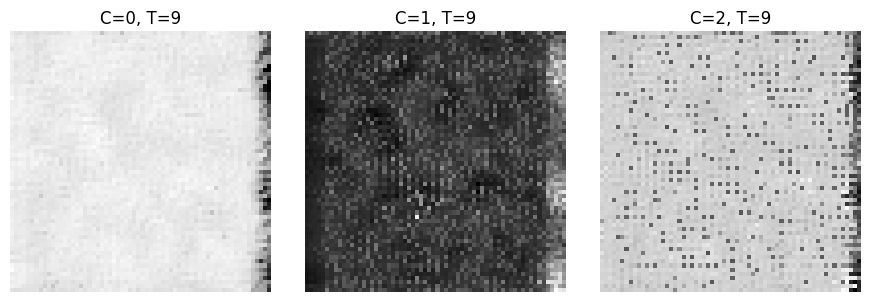

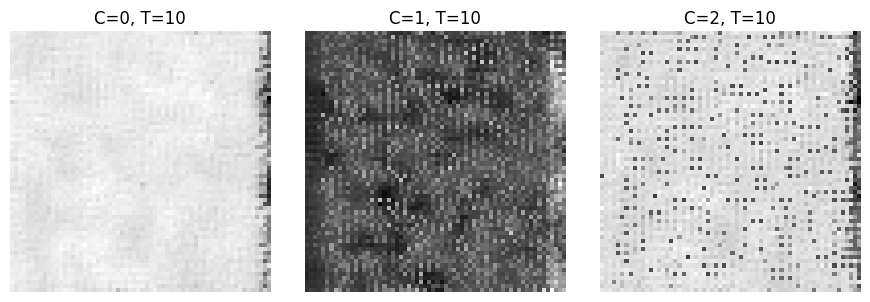

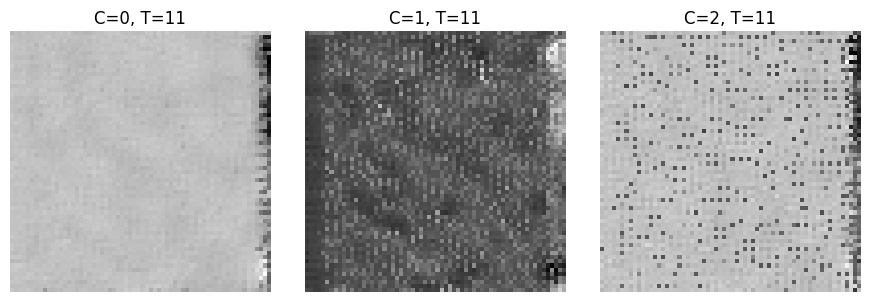

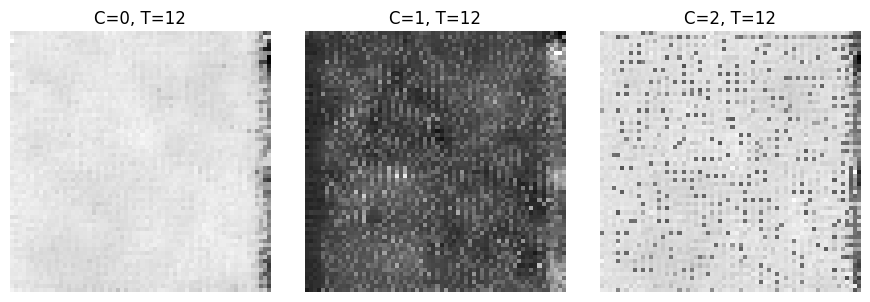

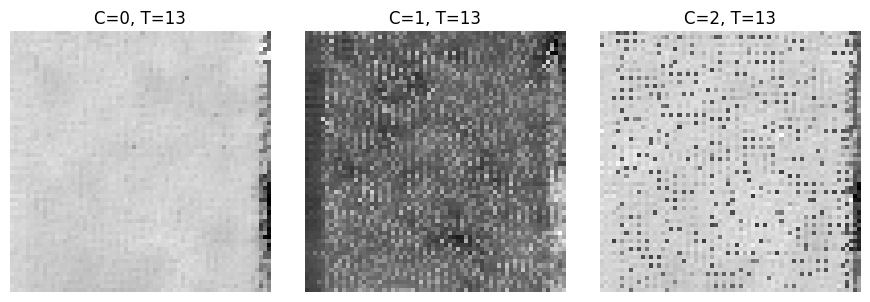

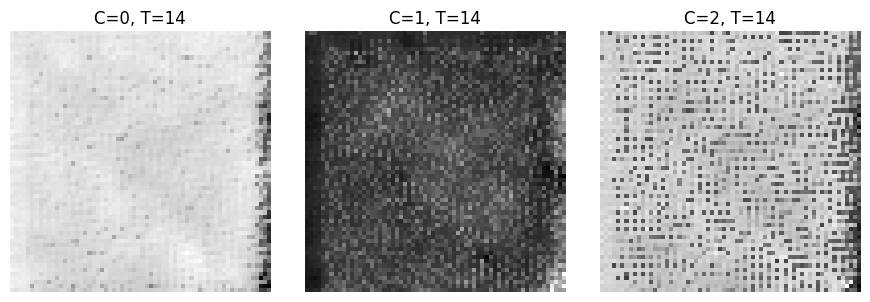

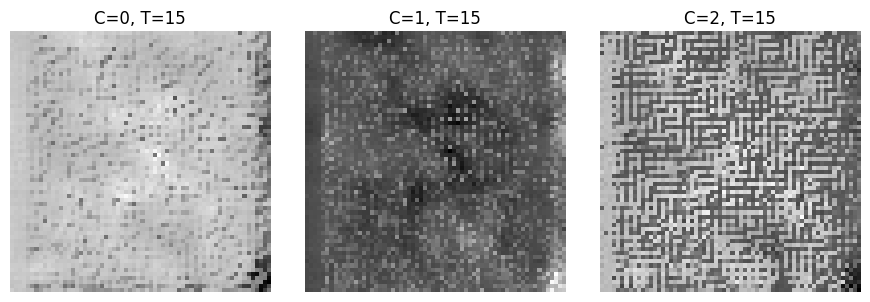

In [19]:
optimized_input = input_tensor.detach().cpu()[0]  # [C, T, H, W]
C, T, H, W = optimized_input.shape

for t in range(T):
    fig, axs = plt.subplots(1, C, figsize=(C * 3, 3))
    for c in range(C):
        axs[c].imshow(optimized_input[c, t], cmap='gray')
        axs[c].set_title(f'C={c}, T={t}')
        axs[c].axis('off')
    plt.tight_layout()
    plt.show()